<a href="https://colab.research.google.com/github/lcqsigi/big-data2/blob/main/ch13_part2_RS.new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a multilayer perceptron for classifying flowers in the Iris dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import tensorflow_datasets as tfds
#iris, iris_info = tfds.load('iris', with_info=True)
#print(tfds.__version__)

In [7]:
import tensorflow as tf
#tf.io.gfile.copy("gs://tfds-data/dataset_info/iris/2.0.0","/content/drive/MyDrive/",overwrite=True)
#tf.io.gfile.exists("gs://tfds-data/dataset_info/iris/2.0.0")
#tf.io.gfile.listdir("gs://tfds-data/dataset_info/iris/2.0.0")
#dir(tf.io.gfile)

In [8]:
!ls -ltr  /root/tensorflow_datasets/iris/2.0.0/iris/2.0.0
#tf.io.gfile.exists("/content/drive/MyDrive/")

total 24
-rw-r--r-- 1 root root 10200 Apr 24 20:19 iris-train.tfrecord-00000-of-00001
-rw-r--r-- 1 root root    43 Apr 24 20:19 label.labels.txt
-rw-r--r-- 1 root root   790 Apr 24 20:19 features.json
-rw-r--r-- 1 root root  1447 Apr 24 20:19 dataset_info.json


In [9]:
iris=tfds.load('iris', data_dir='/root/tensorflow_datasets/iris/2.0.0/', download=False)
#builder=tfds.builder_from_directory('/root/tensorflow_datasets/iris/2.0.0/')
#!ls -ltr  drive/MyDrive
#builder2 = tfds.builder('iris')
#builder2.download_and_prepare()

In [10]:
iris

{'train': <_PrefetchDataset element_spec={'features': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [11]:
#!pwd
#!cat /root/tensorflow_datasets/downloads/arch.ics.uci.edu_ml_mach-lear-data_iris_ib2CLcacxchYxm00ntNm8hOar1zTtp4crcaRYVp4mVsA.data
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [12]:
#!tar -xvf  /root/tensorflow_datasets/iris/2.0.0/files.tar

In [13]:
tf.random.set_seed(1)

ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)

print(next(iter(ds_orig)))

ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=2>}


In [14]:
## checking the number of examples:

n = 0
for example in ds_train_orig:
    n += 1
print(n)


n = 0
for example in ds_test:
    n += 1
print(n)

100
50


In [15]:
ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

next(iter(ds_train_orig))

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>)

In [16]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])

iris_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [17]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [18]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)

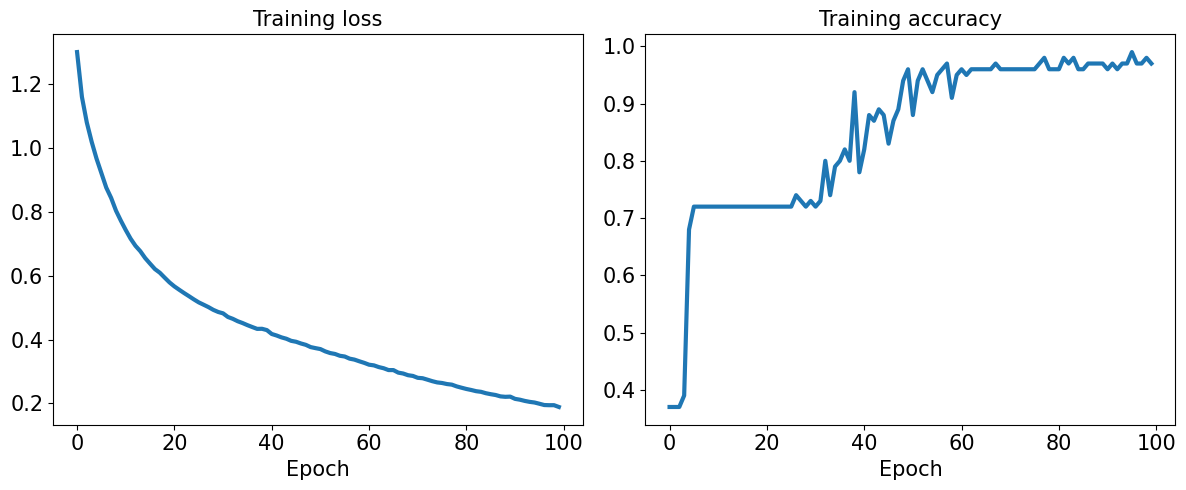

In [19]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('ch13-cls-learning-curve.pdf')

plt.show()

### Evaluating the trained model on the test dataset

In [20]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1913   Test Acc.: 0.9800


### Saving and reloading the trained model

In [21]:
iris_model.save('iris-classifier.h5', 
                overwrite=True,
                include_optimizer=True,
                save_format='h5')

In [22]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

iris_model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [23]:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1913   Test Acc.: 0.9800


In [24]:
labels_train = []
for i,item in enumerate(ds_train_orig):
    labels_train.append(item[1].numpy())
    
labels_test = []
for i,item in enumerate(ds_test):
    labels_test.append(item[1].numpy())
print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))

Training Set:  100 Test Set:  50


In [25]:
iris_model_new.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 4], "dtype": "float32", "sparse": false, "ragged": false, "name": "fc1_input"}}, {"class_name": "Dense", "config": {"name": "fc1", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 4], "units": 16, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "fc2", "trainable": true, "dtype": "float32", "units": 3, "activation": "softmax", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regu